## 1. Setup

In [1]:
import os
import typing as t

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import utils as utls
from torch.profiler import profile, record_function, ProfilerActivity, schedule

import snntorch as snn
from snntorch import utils
from snntorch import surrogate

import tonic
import tonic.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import seaborn as sns
import umap

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(25,15)})

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## 2. Datasets

In [2]:
# General settings
base_path = 'E:/LTU/X7013E/'

# Dataloader arguments
batch_size = 64
sensor_size = tonic.datasets.NMNIST.sensor_size
cropped_size = (32, 32)

transform = transforms.Compose([
    transforms.CenterCrop(sensor_size=sensor_size, size=cropped_size),
    transforms.ToFrame(sensor_size=(*cropped_size, 2), n_time_bins=32), #time_window=10000), # us to 1 ms
    ])

# Training data
train_dataset = tonic.datasets.NMNIST(save_to=base_path + 'data/nmnist', transform=transform, train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=True)

# Testing data
#test_dataset = tonic.datasets.NMNIST(save_to=base_path + 'data/nmnist', train=False)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [3]:
# Utility functions

# Used to find maximum batch size without overflowing the memory
def get_max_batch_size(
    model: nn.Module,
    device: torch.device,
    optimizer: torch.optim,
    input_shape: t.Tuple[int, int, int],
    output_shape: t.Tuple[int],
    dataset_size: int,
    max_batch_size: int = None,
    num_iterations: int = 5,
) -> int:
    model.to(device)
    model.train(True)

    batch_size = 2
    while True:
        if max_batch_size is not None and batch_size >= max_batch_size:
            batch_size = max_batch_size
            break
        if batch_size >= dataset_size:
            batch_size = batch_size // 2
            break
        try:
            for _ in range(num_iterations):
                # dummy inputs and targets
                inputs = torch.rand(*(batch_size, *input_shape), device=device)
                targets = torch.rand(*(batch_size, *output_shape), device=device)
                outputs = model(inputs)
                loss = F.mse_loss(targets, outputs)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            batch_size *= 2
        except RuntimeError:
            batch_size //= 2
            break
    del model, optimizer
    torch.cuda.empty_cache()
    
    print(f'Maximum batch size achieved: {batch_size}')
    print('Remember to restart kernel before continuing to free up memory!')
    
    return batch_size

In [4]:
# Plotting functions
def plot_2d_hist(image_3d, frames=None):
    """ Expect input image_3d in form of (channels, time/frames, y/rows, x/cols)
        Frames variable expects a list of frames to show (no list = all frames)
    """
    channels, depth, height, width = image_3d.shape
    fig, ax = plt.subplots(nrows=1, ncols=channels, figsize=(5*channels, 5))
    ax[0].set_title("On-spikes")
    ax[1].set_title("Off-spikes")
    
    for i in range(channels):
        events = np.array(np.where(image_3d[i]==1.0))
        
        event_depth = np.array(events[0])
        
        if frames:
            mask = np.zeros(event_depth.shape)
            # Add all frame masks together
            for frame in frames:
                mask = np.add(mask, event_depth == frame).astype(bool)
        else:
            mask = np.ones(event_depth.shape).astype(bool)
        
        event_width = np.array(events[2])[mask]
        event_height = np.array(events[1])[mask]
        
        data, x, y = np.histogram2d(event_width, event_height, bins=(32,32), range=([[0, width-1], [0, height-1]]))

        plt.subplot(1, channels, i + 1)
        plt.imshow(data.T)
        
def plot_3d_scatter(image_3d):
    """ Expect input in form of (batches, channels, time, y/rows, x/cols)
    """
    batch_size, channels, depth, height, width = image_3d.shape
    
    nrows = 25
    ncols = int(np.ceil(batch_size/25))
    
    fig = plt.figure(figsize=(10*ncols, 5*nrows))
    # Handle batches
    for i in range(batch_size):
        ax = fig.add_subplot(nrows, ncols, i+1, projection="3d")
        events = np.where(image_3d[i][0]==1.0)
        
        event_width = events[2]
        event_height = events[1]
        event_depth = events[0]

        ax.scatter(event_width, event_depth, event_height, marker=".", c=event_depth, cmap="tab10")
        #ax.set_title(f"Digit {label}")
        ax.set_title(f"Batch {i+1}")
        ax.set_xlabel("x")
        ax.set_ylabel("Time [s]")
        ax.set_zlabel("y")
        
        ax.set_xlim(0, width)
        ax.set_ylim(0, depth)
        ax.set_zlim(0, height)
        ax.invert_zaxis()
        #print(f"Digit {index} is represented by {len(events)} events")
        break
    
    plt.tight_layout()  # Adjust subplot layout to prevent overlapping
    plt.show()
    
def animate_plot(images_3d):
    """ Expect input in form of a list of images with
        format per image as (channels, time/frames, y/rows, x/cols)
    """
    n_images = len(images_3d)
    n_channels = images_3d[0].shape[0]
    n_frames = images_3d[0].shape[1]
    fig, ax = plt.subplots(nrows=n_channels, ncols=n_images, figsize=(5*n_images, 10))
        
    def animate(frame):
        for i, image_3d in enumerate(images_3d):
            channels, depth, height, width = image_3d.shape
            events_pos = np.array(np.where(image_3d[0] >= 0.5))
            events_neg = np.array(np.where(image_3d[1] >= 0.5))
    
            # On-spikes
            mask = events_pos[0] == frame # depth
            x = events_pos[2][mask] # width
            y = events_pos[1][mask] # height
            data, _, _ = np.histogram2d(x, y, bins=(width,height), range=([[0, width-1], [0, height-1]]))
            plt.subplot(n_channels, n_images, 1+i*n_channels)
            plt.imshow(data.T)
            plt.ylabel("On-spikes")
            
            # Off-spikes
            mask = events_neg[0] == frame # depth
            x = events_neg[2][mask] # width
            y = events_neg[1][mask] # height  
            data, _, _ = np.histogram2d(x, y, bins=(width,height), range=([[0, width-1], [0, height-1]])) 
            plt.subplot(n_channels, n_images, 2+i*n_channels)
            plt.imshow(data.T)
            plt.ylabel("Off-spikes")

    ani = animation.FuncAnimation(fig=fig, func=animate, frames=n_frames)
    return ani

# Encode data and collect latent representations
# !!! Need some fixing !!!
def plot_latent_dim(net, dataloader):
    latent_data = []
    latent_labels = []
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(dataloader):
            images = images.permute(0, 2, 1, 3, 4).to(device) # Swap channel and depth pos
            encoded = net.forward_encode(images)
            latent_data.append(encoded)
            latent_labels.append(labels)
            if batch_idx >= 10:
                break
                   
    latent_data = torch.cat(latent_data, dim=0).to('cpu').numpy()
    print(latent_data.shape)
    latent_labels = torch.cat(latent_labels, dim=0).to('cpu').numpy()
    
    # Apply UMAP to reduce dimensionality
    latent_data_flattened = latent_data.reshape(latent_data.shape[0], -1)     
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(latent_data_flattened)
    
    plt.scatter(embedding[:, 0], embedding[:, 1], c=latent_labels, cmap='Spectral', s=5)
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.title('UMAP projection of AE latent layer', fontsize=24)
    

In [5]:
# Fetch one batch of events from dataloader
'''for events, labels in train_loader:
    output = events.permute(0, 2, 1, 3, 4)
    break

images = [output[0]] # Select one image from batch

# Plot image
plot_2d_hist(output[0]) # 
plot_3d_scatter(output)

#ani = animate_plot(images)
#HTML(ani.to_jshtml()) # Required for interactive animation in notebook
#ani.save(filename=base_path + f'figures/training/test.html', writer="html")'''

'for events, labels in train_loader:\n    output = events.permute(0, 2, 1, 3, 4)\n    break\n\nimages = [output[0]] # Select one image from batch\n\n# Plot image\nplot_2d_hist(output[0]) # \nplot_3d_scatter(output)\n\n#ani = animate_plot(images)\n#HTML(ani.to_jshtml()) # Required for interactive animation in notebook\n#ani.save(filename=base_path + f\'figures/training/test.html\', writer="html")'

## 3. SAE Models:

#### Fully connected layers

In [6]:
class SAE_FC(nn.Module):
    def __init__(self):
        super().__init__()
        #Encoder
        self.encoder = nn.Sequential(
            nn.Linear(2*34*34, 128),
            #nn.BatchNorm2d(32),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, threshold=thresh),
            #nn.Linear(128, 64),
            #nn.BatchNorm2d(64),
            #snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, threshold=thresh),
            #nn.Linear(64, 32),
            #nn.BatchNorm2d(128),
            #snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, threshold=thresh),
            nn.Linear(128, 16), #this needs to be the final layer output size (channels * pixels * pixels)
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True, threshold=thresh)
            )

        #Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 128),
            #nn.BatchNorm2d(64),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, threshold=thresh),
            #nn.Linear(32, 64),
            #nn.BatchNorm2d(32),
            #snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, threshold=thresh),
            #nn.Linear(64, 128),
            #snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, threshold=thresh),
            nn.Linear(128, 2*34*34),
            snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True,threshold=20000), #make large so membrane can be trained
            )
        
    def forward(self, x): #Dimensions: [Batch,Channels,Width,Length]
        utils.reset(self.encoder) #need to reset the hidden states of LIF 
        utils.reset(self.decoder)
        #utils.reset(self.linearNet)
        #print(f'x shape: {x.shape}')
        num_steps = x.shape[0]

        spk_mem=[]; spk_rec=[]; encoded_x=[]
        spk_mem2=[]; spk_rec2=[]; decoded_x=[]
        
        for step in range(num_steps): #for t in time
            #encode
            spk_x, mem_x = self.encode(x[step]) #Output spike trains and neuron membrane states
            spk_rec.append(spk_x) 
            spk_mem.append(mem_x)
            
            #decode
            x_recon, x_mem_recon = self.decode(spk_x)
            spk_rec2.append(x_recon)
            spk_mem2.append(x_mem_recon)
                     
        spk_rec=torch.stack(spk_rec, dim=0)
        spk_mem=torch.stack(spk_mem, dim=0) # Dimensions:[Time, Batch, Channels]
        
        spk_rec2=torch.stack(spk_rec2, dim=0)
        spk_mem2=torch.stack(spk_mem2, dim=0) # Dimensions:[Time, Batch, Channels]
        
        out = spk_mem2#[:,:,:,:,-1] #return the membrane potential of the output neuron at t = -1 (last t)
        return out #Dimensions:[Batch,Channels,Width,Length]

    def encode(self, x):
        spk_latent_x, mem_latent_x = self.encoder(x) 
        return spk_latent_x, mem_latent_x

    def decode(self, x):
        #spk_x,mem_x = self.linearNet(x) #convert latent dimension back to total size of features in encoder final layer
        spk_x2, mem_x2 = self.decoder(x)
        return spk_x2, mem_x2

In [7]:
def train_fc(network, trainloader, optimizer, epoch): 
    
    network = network.train()
    train_loss_hist=[]
    for batch_idx, (events, labels) in enumerate(trainloader):
        events = events.to(device)
        events_flattened = events.reshape(events.shape[0], events.shape[1], -1).to(device) # Image flattened so polarity, height and width (2, 34, 34)-> (2312)
        labels = labels.to(device)
        
        #Pass data into network, and return reconstructed image from Membrane Potential at t = -1
        events_recon = network(events_flattened) #Dimensions passed in: [Timesteps, Batch_size, Flattened_image] 
        events_recon = events_recon.reshape(events.shape)
        
        #Calculate loss        
        loss_val = F.mse_loss(events_recon, events)
                
        print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val.item()}')

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        #Save reconstructed images every at the end of the epoch
        if batch_idx == 10: #len(trainloader)-1:
            events_for_image = events[99, :, :, :, :]
            events_for_image_recon = events_recon[99, :, :, :, :]
            utls.save_image((events_for_image + 1) / 2, base_path + f'figures/training/epoch{epoch}_finalbatch_inputs.png') 
            utls.save_image((events_for_image_recon + 1) / 2, base_path + f'figures/training/epoch{epoch}_finalbatch_recon.png')
    return loss_val


In [8]:
def test(network, testloader, opti, epoch):
    network=network.eval()
    test_loss_hist=[]
    with torch.no_grad(): #no gradient this time
        for batch_idx, (real_img, labels) in enumerate(testloader):   
            real_img = real_img.to(device)#
            labels = labels.to(device)
            x_recon = network(real_img)

            loss_val = F.mse_loss(x_recon, real_img)

            print(f'Test[{epoch}/{max_epoch}][{batch_idx}/{len(testloader)}]  Loss: {loss_val.item()}')#, RECONS: {recons_meter.avg}, DISTANCE: {dist_meter.avg}')
                
            if batch_idx == len(testloader)-1:
                utls.save_image((real_img+1)/2, f'figures/testing/epoch{epoch}_finalbatch_inputs.png')
                utls.save_image((x_recon+1)/2, f'figures/testing/epoch{epoch}_finalbatch_recons.png')
    return loss_val

There are a couple of ways to calculate loss with spiking neural networks. Here, we are simply taking the membrane potential of the final fully-connected layer of neurons at the last time step ($t = 5$). 

Therefore, we only need to compare each original image with its corresponding decoded, reconstructed image once per epoch. We can also return the membrane potentials at each time step, and create t different versions of the reconstructed image, and then compare each of them with the original image and take the average loss. For those of you interested in this, you can replace the loss function above with something like this:

(*note this will fail to run as we have not defined any of the variables yet, it is just here for illustrative purposes*)

In [9]:
'''train_loss_hist=[]
loss_val = torch.zeros((1), dtype=dtype, device=device)
for step in range(num_steps):
    loss_val += F.mse_loss(x_recon, real_img)
train_loss_hist.append(loss_val.item())
avg_loss=loss_val/num_steps'''

'train_loss_hist=[]\nloss_val = torch.zeros((1), dtype=dtype, device=device)\nfor step in range(num_steps):\n    loss_val += F.mse_loss(x_recon, real_img)\ntrain_loss_hist.append(loss_val.item())\navg_loss=loss_val/num_steps'

#### CNN

In [10]:
class SAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_path = self.create_folders()
        
        # Hyperparameters
        #self.spike_grad = surrogate.atan(alpha=2.0)# alternate surrogate gradient fast_sigmoid(slope=25) 
        self.spike_grad = surrogate.fast_sigmoid(slope=25)
        self.beta = 0.5 # Decay rate of neurons 
        self.num_steps = 5
        self.latent_dim = 32 # Dimension of latent layer (how compressed we want the information)
        self.thresh = 1 # Spiking threshold (lower = more spikes are let through)
        
        # Network layers are defined per specific network below
        
    def forward(self, x): #Dimensions: [Batch,Channels,Width,Length]
        # Reset hidden states of LIF 
        utils.reset(self.encoder)
        utils.reset(self.decoder)
        utils.reset(self.linearNet) 
        
        # Encode
        spk_mem = []
        spk_rec = []
        for step in range(self.num_steps): # For t in time
            spk_x, mem_x = self.encode(x) # Output spike trains and neuron membrane states
            spk_rec.append(spk_x) 
            spk_mem.append(mem_x)
        spk_rec=torch.stack(spk_rec, dim=2)
        spk_mem=torch.stack(spk_mem, dim=2) # Dimensions:[Batch, Channels, Width, Length, Time]
        #spk_mem=torch.sum(spk_mem, dim=2) # Summing all spikes 
        #print(spk_mem.shape)
        encoding = spk_mem[...,step].squeeze()
        
        # Decode
        spk_mem2=[]
        spk_rec2=[]
        for step in range(self.num_steps): #for t in time
            x_recon, x_mem_recon = self.decode(spk_rec[...,step]) 
            spk_rec2.append(x_recon) 
            spk_mem2.append(x_mem_recon)
        spk_rec2 = torch.stack(spk_rec2, dim=4)
        spk_mem2 = torch.stack(spk_mem2, dim=4) # Dimensions:[Batch, Channels, Width, Length, Time]  
        out = spk_mem2[:,:,:,:,-1] # Return the membrane potential of the output neuron at t = -1 (last t)
        return out, encoding # Dimensions:[Batch, Channels, Width, Length]
    
    def forward_encode(self, x):
        utils.reset(self.encoder) # Need to reset the hidden states of LIF
        
        # Encode
        spk_mem = []
        spk_rec = []
        for step in range(self.num_steps): # For t in time
            spk_x, mem_x = self.encode(x) #Output spike trains and neuron membrane states
            spk_rec.append(spk_x) 
            spk_mem.append(mem_x)
        spk_rec=torch.stack(spk_rec, dim=2).squeeze()
        spk_mem=torch.stack(spk_mem, dim=2).squeeze() #Dimensions:[Batch, Channels, Width, Length, Time]
        return spk_mem

    def encode(self, x):
        spk_latent_x, mem_latent_x = self.encoder(x) 
        return spk_latent_x, mem_latent_x

    def decode(self, x):
        spk_x, mem_x = self.linearNet(x) # Convert latent dimension back to total size of features in encoder final layer
        spk_x2, mem_x2 = self.decoder(spk_x)
        return spk_x2, mem_x2
    
    def train_net(self, trainloader, optimizer, max_batch, start_epoch, max_epoch, save_output=False, save_model=False):
        self.train()
        train_loss_hist= []
        latent_data = []
        latent_labels = []
        for epoch in range(start_epoch, max_epoch):
            for batch_idx, (real_img, labels) in enumerate(trainloader):
                # Stop if max batches reached
                if batch_idx >= max_batch:
                    break
                
                real_img = self.preprocess_image(real_img).to(device)
                
                # Pass data into network, and return reconstructed image from Membrane Potential at t = -1
                x_recon, encoding = self(real_img)
                latent_data.append(encoding.detach())
                latent_labels.append(labels)
                
                # Calculate loss        
                loss = F.mse_loss(x_recon, real_img)
                loss_val = loss.item()
                train_loss_hist.append(loss_val)
                        
                print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val}')

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if (batch_idx == len(trainloader) - 1) and save_output:
                #if (batch_idx == max_batch - 1) and save_output:
                    # Save output
                    self.save_output(real_img, x_recon, epoch, mode="training")
                    self.plot_umap(latent_data, latent_labels, epoch, mode="training")

                    # Store model
                    if save_model:
                        torch.save(self.state_dict(), f'{self.model_path}/models/epoch{epoch}.pth')               

        return train_loss_hist
    
    def test_net(self, testloader, max_batch, start_epoch, max_epoch, save_output=False):
        self.eval()
        test_loss_hist= []
        latent_data = []
        latent_labels = []
        with torch.no_grad():
            for epoch in range(start_epoch, max_epoch):
                for batch_idx, (real_img, labels) in enumerate(testloader):
                    # Stop if max batches reached
                    if batch_idx >= max_batch:
                        break
                
                    real_img = self.preprocess_image(real_img).to(device)
                    
                    # Pass data into network, and return reconstructed image from Membrane Potential at t = -1
                    x_recon, encoding = self(real_img)
                    latent_data.append(encoding)
                    latent_labels.append(labels)

                    # Calculate loss        
                    loss = F.mse_loss(x_recon, real_img)
                    loss_val = loss.item()
                    test_loss_hist.append(loss_val)

                    print(f'Test[{epoch}/{max_epoch}][{batch_idx}/{len(testloader)}] Loss: {loss_val}')
                        
                    if (batch_idx == len(testloader) - 1) and save_output:
                        # Save output
                        self.save_output(real_img, x_recon, epoch, mode="testing")
                
                # Plot latent layer
                if save_output:
                    self.plot_umap(latent_data, latent_labels, epoch, moce="testing")
        return loss_val
    
    # Encode data and collect latent representations
    def plot_umap(self, data, labels, epoch, mode):                            
        data = torch.cat(data, dim=0).to('cpu').numpy()
        labels = torch.cat(labels, dim=0).to('cpu').numpy()
        
        # Apply UMAP to reduce dimensionality
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(data)
        
        plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=10)
        plt.gca().set_aspect('equal', 'datalim')
        plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
        plt.title('UMAP projection of AE latent layer', fontsize=24)
        plt.savefig(f'{self.model_path}/figures/{mode}/UMAP_{epoch}.png')
        plt.close()
    
    def create_folders(self):
        # Create necessary folders in the specified base_path
        model_path = f'{base_path}/{type(self).__name__}'
        
        if not os.path.isdir(f'{model_path}/figures/training'):
            os.makedirs(f'{model_path}/figures/training')
        if not os.path.isdir(f'{model_path}/figures/testing'):
            os.makedirs(f'{model_path}/figures/testing')
        if not os.path.isdir(f'{model_path}/models'):
            os.makedirs(f'{model_path}/models')
        
        return model_path
    
    def preprocess_image(self, image):
        # Define this for each network below
        # If no preprocess is defined, do nothing
        return image
    
    def save_output(self, real_img, x_recon, epoch):
        # Define this for each network below
        # If no save output is defined, do nothing
        pass
    
    def load_model(self, epoch):
        try:
            self.load_state_dict(torch.load(f'{self.model_path}/models/epoch{epoch}.pth'))
        except FileNotFoundError:
            print("Error: Model file not found.")
    

In [11]:
class SAE_2Dconv(SAE):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1, stride=2),
                          nn.BatchNorm2d(32),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.Conv2d(32, 64, 3, padding=1, stride=2),
                          nn.BatchNorm2d(64),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.Conv2d(64, 128, 3, padding=1, stride=2),
                          nn.BatchNorm2d(128),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.Flatten(start_dim = 1, end_dim = 3),
                          nn.Linear(128*4*4, self.latent_dim), #this needs to be the final layer output size (channels * pixels * pixels)
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, output=True, threshold=self.thresh)
                          )
        # From latent back to tensor for convolution
        self.linearNet= nn.Sequential(nn.Linear(self.latent_dim, 128*4*4),
                               snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, output=True,threshold=self.thresh))        
        # Decoder
        self.decoder = nn.Sequential(nn.Unflatten(1, (128, 4, 4)), 
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.ConvTranspose2d(128, 64, 3, padding=1, stride=(2,2), output_padding=1),
                          nn.BatchNorm2d(64),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.ConvTranspose2d(64, 32, 3, padding=1, stride=(2,2), output_padding=1),
                          nn.BatchNorm2d(32),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.ConvTranspose2d(32, 1, 3, padding=1, stride=(2,2), output_padding=1),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, output=True, threshold=20000) #make large so membrane can be trained
                          )
    
    def preprocess_image(self, image):
        # Data returned as: [Batch_size, Channels, Image_Height, Image_Width]
        return image[:,0,0,:,:].unsqueeze(1)
    
    def save_output(self, real_img, x_recon, epoch, mode):
        #Save reconstructed images every at the end of the epoch
        # NOTE: you need to create training/ and testing/ folders in your chosen path
            utls.save_image((real_img + 1) / 2, f'{self.model_path}/figures/{mode}/epoch{epoch}_finalbatch_inputs.png')
            utls.save_image((x_recon + 1) / 2, f'{self.model_path}/figures/{mode}/epoch{epoch}_finalbatch_recon.png')

In [12]:
class SAE_2DconvTT(SAE):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(nn.Conv2d(2, 32, 3, padding=1, stride=2),
                          nn.BatchNorm2d(32),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.Conv2d(32, 64, 3, padding=1, stride=2),
                          nn.BatchNorm2d(64),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.Conv2d(64, 128, 3, padding=1, stride=2),
                          nn.BatchNorm2d(128),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.Flatten(start_dim = 1, end_dim = 3),
                          nn.Linear(128*4*4, self.latent_dim), #this needs to be the final layer output size (channels * pixels * pixels)
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, output=True, threshold=self.thresh)
                          )
        # From latent back to tensor for convolution
        self.linearNet= nn.Sequential(nn.Linear(self.latent_dim, 128*4*4),
                               snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, output=True,threshold=self.thresh))        
        # Decoder
        self.decoder = nn.Sequential(nn.Unflatten(1, (128, 4, 4)), 
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.ConvTranspose2d(128, 64, 3, padding=1, stride=(2,2), output_padding=1),
                          nn.BatchNorm2d(64),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.ConvTranspose2d(64, 32, 3, padding=1, stride=(2,2), output_padding=1),
                          nn.BatchNorm2d(32),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.ConvTranspose2d(32, 2, 3, padding=1, stride=(2,2), output_padding=1),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, output=True, threshold=20000) #make large so membrane can be trained
                          )
        
    def train_net(self, trainloader, optimizer, max_batch, start_epoch, max_epoch, save_output=False, save_model=False):
        self.train()
        train_loss_hist= []
        latent_data = []
        latent_labels = []
        for epoch in range(start_epoch, max_epoch):
            for batch_idx, (real_img, labels) in enumerate(trainloader):
                # Stop if max batches reached
                if batch_idx >= max_batch:
                    break
                
                real_img = self.preprocess_image(real_img).to(device)
                
                frames_recon = []
                for i in range(real_img.shape[2]):
                    # Pass data into network, and return reconstructed image from Membrane Potential at t = -1
                    frame = real_img[:,:,i,:,:]                
                    frame_recon, encoding = self(frame)
                    frames_recon.append(frame_recon)
                    
                    latent_data.append(encoding.detach())
                    latent_labels.append(labels)
                
                #x_recon.unsqueeze(2)
                x_recon = torch.stack(frames_recon, dim=2)
                    
                # Calculate loss        
                loss = F.mse_loss(x_recon, real_img)
                loss_val = loss.item()
                train_loss_hist.append(loss_val)
                        
                print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val}')

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if (batch_idx == len(trainloader) - 1) and save_output:
                #if (batch_idx == max_batch - 1) and save_output:
                    # Save output
                    self.save_output(real_img, x_recon, epoch, mode="training")
                    self.plot_umap(latent_data, latent_labels, epoch, mode="training")

            # Store model
            if save_model:
                torch.save(self.state_dict(), f'{self.model_path}/models/epoch{epoch}.pth')               

        return train_loss_hist
    
    def preprocess_image(self, image):
        # Data returned as: [Batch_size, Channels, Image_Depth, Image_Height, Image_Width]
        return image.permute(0, 2, 1, 3, 4)
    
    def save_output(self, real_img, x_recon, epoch, mode):
        # Save animation of one digit at the end of each epoch
        images = [real_img[0].cpu(), x_recon[0].cpu()]
        ani = animate_plot(images)
        #HTML(ani.to_jshtml())
        ani.save(filename=f'{self.model_path}/figures/{mode}/epoch{epoch}_image0.html', writer="html")
        plt.close()

In [13]:
class SAE_3Dconv(SAE):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(nn.Conv3d(2, 32, 3, padding=1, stride=2),
                          nn.BatchNorm3d(32),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.Conv3d(32, 64, 3, padding=1,stride=2),
                          nn.BatchNorm3d(64),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.Conv3d(64, 128, 3, padding=1,stride=2),
                          nn.BatchNorm3d(128),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.Flatten(start_dim = 1, end_dim = 4),
                          nn.Linear(128*4*4*4, self.latent_dim), #this needs to be the final layer output size (channels * pixels * pixels)
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, output=True, threshold=self.thresh)
                          )
        # From latent back to tensor for convolution
        self.linearNet= nn.Sequential(nn.Linear(self.latent_dim, 128*4*4*4),
                               snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, output=True,threshold=self.thresh))        
        # Decoder
        self.decoder = nn.Sequential(nn.Unflatten(1, (128, 4, 4, 4)), 
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.ConvTranspose3d(128, 64, 3, padding=1, stride=(2,2,2), output_padding=1),
                          nn.BatchNorm3d(64),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.ConvTranspose3d(64, 32, 3, padding=1, stride=(2,2,2), output_padding=1),
                          nn.BatchNorm3d(32),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.ConvTranspose3d(32, 2, 3, padding=1, stride=(2,2,2), output_padding=1),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, output=True, threshold=20000) #make large so membrane can be trained
                          )
        
    def preprocess_image(self, image):
        # Data returned as: [Batch_size, Channels, Image_Depth, Image_Height, Image_Width]
        return image.permute(0, 2, 1, 3, 4)
    
    def save_output(self, real_img, x_recon, epoch, mode):
        # Save animation of one digit at the end of each epoch
        images = [real_img[0].cpu(), x_recon[0].cpu()]
        ani = animate_plot(images)
        #HTML(ani.to_jshtml())
        ani.save(filename=f'{self.model_path}/figures/{mode}/epoch{epoch}_image0.html', writer="html")
        plt.close()


In [14]:
class SAE_3DconvTT(SAE):
    def __init__(self):
        super().__init__()    
        # Encoder
        self.conv1 = nn.Conv3d(2, 32, 3, padding=1, stride=2)
        self.bn1 = nn.ModuleList([nn.BatchNorm3d(32) for i in range(self.num_steps)])
        self.lif1 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.conv2 = nn.Conv3d(32, 64, 3, padding=1, stride=2)
        self.bn2 = nn.ModuleList([nn.BatchNorm3d(64) for i in range(self.num_steps)])
        self.lif2 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.conv3 = nn.Conv3d(64, 128, 3, padding=1, stride=2)
        self.bn3 = nn.ModuleList([nn.BatchNorm3d(128) for i in range(self.num_steps)])
        self.lif3 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.flatten = nn.Flatten(start_dim = 1, end_dim = 4)
        self.fc1 = nn.Linear(128*4*4*4, self.latent_dim) #this needs to be the final layer output size (channels * pixels * pixels)
        self.lif4 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, output=True, threshold=self.thresh)
        
        # From latent back to tensor for convolution
        self.fc2 = nn.Linear(self.latent_dim, 128*4*4*4)
        self.lif5 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, output=True, threshold=self.thresh)
             
        # Decoder
        self.unflatten = nn.Unflatten(1, (128, 4, 4, 4))
        self.lif6 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.convT1 = nn.ConvTranspose3d(128, 64, 3, padding=1, stride=(2,2,2), output_padding=1)
        self.bn4 = nn.ModuleList([nn.BatchNorm3d(64) for i in range(self.num_steps)])
        self.lif7 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.convT2 = nn.ConvTranspose3d(64, 32, 3, padding=1, stride=(2,2,2), output_padding=1)
        self.bn5 = nn.ModuleList([nn.BatchNorm3d(32) for i in range(self.num_steps)])
        self.lif8 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.convT3 = nn.ConvTranspose3d(32, 2, 3, padding=1, stride=(2,2,2), output_padding=1)
        self.lif9 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, output=True, threshold=20000) #make large so membrane can be trained
        
        self.lif_list = [self.lif1, self.lif2, self.lif3, self.lif4, self.lif5, self.lif6, self.lif7, self.lif8, self.lif9]
        self.bn_list = [self.bn1, self.bn2, self.bn3, self.bn4, self.bn5]
        
        self.apply(self._init_weights)
     
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()
    
    def forward(self, x): #Dimensions: [Batch,Channels,Width,Length]
        # Reset hidden states of LIF
        mem1 = self.lif1.init_leaky() # reset/init hidden states at t=0
        mem2 = self.lif2.init_leaky() # reset/init hidden states at t=0
        mem3 = self.lif1.init_leaky() # reset/init hidden states at t=0
        mem4 = self.lif2.init_leaky() # reset/init hidden states at t=0
        mem5 = self.lif1.init_leaky() # reset/init hidden states at t=0
        mem6 = self.lif2.init_leaky() # reset/init hidden states at t=0
        mem7 = self.lif1.init_leaky() # reset/init hidden states at t=0
        mem8 = self.lif2.init_leaky() # reset/init hidden states at t=0
        mem9 = self.lif1.init_leaky() # reset/init hidden states at t=0
        
        # Encode
        spk_mem = []
        spk_rec = []
        for step in range(self.num_steps): # For t in time
            # Encoder
            cur1 = self.conv1(x)
            cur1 = self.bn1[step](cur1)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.conv2(spk1)
            cur2 = self.bn2[step](cur2)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.conv3(spk2)
            cur3 = self.bn3[step](cur3)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3 = self.flatten(spk3)
            cur4 = self.fc1(spk3)
            spk_enc, mem_enc = self.lif4(cur4, mem4) # Output spike trains and neuron membrane states
            
            spk_rec.append(spk_enc)
            spk_mem.append(mem_enc)
            
        spk_rec=torch.stack(spk_rec, dim=2)
        spk_mem=torch.stack(spk_mem, dim=2) # Dimensions:[Batch, Channels, Width, Length, Time]
        
        encoding = spk_mem[...,step].squeeze()
        
        # Decode
        spk_mem2=[]
        spk_rec2=[]
        for step in range(self.num_steps): #for t in time
            # Latent
            cur5 = self.fc2(spk_rec[...,step])
            spk5, mem5 = self.lif5(cur5, mem5)
            
            # Decoder
            cur6 = self.unflatten(spk5)
            spk6, mem6 = self.lif6(cur6, mem6)
            cur7 = self.convT1(spk6)
            cur7 = self.bn4[step](cur7)
            spk7, mem7 = self.lif7(cur7, mem7)
            cur8 = self.convT2(spk7)
            cur8 = self.bn5[step](cur8)
            spk8, mem8 = self.lif8(cur8, mem8)
            cur9 = self.convT3(spk8)
            spk9, mem9 = self.lif9(cur9, mem9) #make large so membrane can be trained
            
            spk_rec2.append(spk9) 
            spk_mem2.append(mem9)
        spk_rec2 = torch.stack(spk_rec2, dim=4)
        spk_mem2 = torch.stack(spk_mem2, dim=4) # Dimensions:[Batch, Channels, Width, Length, Time]  
        out = spk_mem2[:,:,:,:,-1] # Return the membrane potential of the output neuron at t = -1 (last t)
        return out, encoding # Dimensions:[Batch, Channels, Width, Length]
        
    def preprocess_image(self, image):
        # Data returned as: [Batch_size, Channels, Image_Depth, Image_Height, Image_Width]
        return image.permute(0, 2, 1, 3, 4)
    
    def save_output(self, real_img, x_recon, epoch, mode):
        # Save animation of one digit at the end of each epoch
        images = [real_img[0].cpu(), x_recon[0].cpu()]
        ani = animate_plot(images)
        #HTML(ani.to_jshtml())
        ani.save(filename=f'{self.model_path}/figures/{mode}/epoch{epoch}_image0.html', writer="html")
        plt.close()
    

In [15]:
class SAE_2DconvTT(SAE):
    def __init__(self):
        super().__init__()
        self.num_time_steps = 32
        
        # Encoder
        self.conv1 = nn.Conv2d(2, 32, 3, padding=1, stride=2)
        self.bn1 = nn.ModuleList([nn.BatchNorm2d(32) for i in range(self.num_time_steps)])
        self.lif1 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1, stride=2)
        self.bn2 = nn.ModuleList([nn.BatchNorm2d(64) for i in range(self.num_time_steps)])
        self.lif2 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.bn3 = nn.ModuleList([nn.BatchNorm2d(128) for i in range(self.num_time_steps)])
        self.lif3 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.flatten = nn.Flatten(start_dim = 1, end_dim = 3)
        self.fc1 = nn.Linear(128*4*4, self.latent_dim) #this needs to be the final layer output size (channels * pixels * pixels)
        self.lif4 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, output=True, threshold=self.thresh)
        
        # From latent back to tensor for convolution
        self.fc2 = nn.Linear(self.latent_dim, 128*4*4)
        self.lif5 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, output=True, threshold=self.thresh)
        
        # Decoder
        self.unflatten = nn.Unflatten(1, (128, 4, 4))
        self.lif6 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.convT1 = nn.ConvTranspose2d(128, 64, 3, padding=1, stride=(2,2), output_padding=1)
        self.bn4 = nn.ModuleList([nn.BatchNorm2d(64) for i in range(self.num_time_steps)])
        self.lif7 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.convT2 = nn.ConvTranspose2d(64, 32, 3, padding=1, stride=(2,2), output_padding=1)
        self.bn5 = nn.ModuleList([nn.BatchNorm2d(32) for i in range(self.num_time_steps)])
        self.lif8 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.convT3 = nn.ConvTranspose2d(32, 2, 3, padding=1, stride=(2,2), output_padding=1)
        self.lif9 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, output=True, threshold=1) #make large so membrane can be trained
        
        self.lif_list = [self.lif1, self.lif2, self.lif3, self.lif4, self.lif5, self.lif6, self.lif7, self.lif8, self.lif9]
        self.bn_list = [self.bn1, self.bn2, self.bn3, self.bn4, self.bn5]
    
    
    def forward(self, x): #Dimensions: [Batch,Channels,Width,Length]
        # Reset hidden states of LIF
        mem1 = self.lif1.init_leaky() # reset/init hidden states at t=0
        mem2 = self.lif2.init_leaky() # reset/init hidden states at t=0
        mem3 = self.lif3.init_leaky() # reset/init hidden states at t=0
        mem4 = self.lif4.init_leaky() # reset/init hidden states at t=0
        mem5 = self.lif5.init_leaky() # reset/init hidden states at t=0
        mem6 = self.lif6.init_leaky() # reset/init hidden states at t=0
        mem7 = self.lif7.init_leaky() # reset/init hidden states at t=0
        mem8 = self.lif8.init_leaky() # reset/init hidden states at t=0
        mem9 = self.lif9.init_leaky() # reset/init hidden states at t=0
        
        # Encode
        spk_mem = []
        spk_rec = []
        for step in range(self.num_time_steps):
            # Pass data into network, and return reconstructed image from Membrane Potential at t = -1
            cur1 = self.conv1(x[:,:,step,:,:]) # Get frame by frame
            cur1 = self.bn1[step](cur1)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.conv2(spk1)
            cur2 = self.bn2[step](cur2)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.conv3(spk2)
            cur3 = self.bn3[step](cur3)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3 = self.flatten(spk3)
            cur4 = self.fc1(spk3)
            spk_enc, mem_enc = self.lif4(cur4, mem4) # Output spike trains and neuron membrane states
            spk_rec.append(spk_enc)
            spk_mem.append(mem_enc)
        
        spk_rec=torch.stack(spk_rec, dim=2)
        spk_mem=torch.stack(spk_mem, dim=2) # Dimensions:[Batch, Channels, Width, Length, Time]
        
        encoding = spk_mem #[...,step].squeeze()
        
        # Decode
        spk_mem2=[]
        spk_rec2=[]
        for step in range(self.num_time_steps): # Get frame by frame
            # Latent
            cur5 = self.fc2(spk_rec[...,step])
            spk5, mem5 = self.lif5(cur5, mem5)
            
            # Decoder
            cur6 = self.unflatten(spk5)
            spk6, mem6 = self.lif6(cur6, mem6)
            cur7 = self.convT1(spk6)
            cur7 = self.bn4[step](cur7)
            spk7, mem7 = self.lif7(cur7, mem7)
            cur8 = self.convT2(spk7)
            cur8 = self.bn5[step](cur8)
            spk8, mem8 = self.lif8(cur8, mem8)
            cur9 = self.convT3(spk8)
            spk9, mem9 = self.lif9(cur9, mem9) #make large so membrane can be trained
            
            spk_rec2.append(spk9) 
            spk_mem2.append(mem9)
        spk_rec2 = torch.stack(spk_rec2, dim=4)
        spk_mem2 = torch.stack(spk_mem2, dim=4) # Dimensions:[Batch, Channels, Width, Length, Time]  
        out = spk_rec2 #[:,:,:,:,-1] # Return the membrane potential of the output neuron at t = -1 (last t)
        return out, encoding # Dimensions:[Batch, Channels, Width, Length]
    
    def forward_encode(self, x): #Dimensions: [Batch,Channels,Width,Length]
        # Reset hidden states of LIF
        mem1 = self.lif1.init_leaky() # reset/init hidden states at t=0
        mem2 = self.lif2.init_leaky() # reset/init hidden states at t=0
        mem3 = self.lif1.init_leaky() # reset/init hidden states at t=0
        mem4 = self.lif2.init_leaky() # reset/init hidden states at t=0
        
        # Encode
        spk_mem = []
        spk_rec = []
        for step in range(self.num_time_steps):
            # Pass data into network, and return reconstructed image from Membrane Potential at t = -1
            cur1 = self.conv1(x[:,:,step,:,:]) # Get frame by frame
            cur1 = self.bn1[step](cur1)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.conv2(spk1)
            cur2 = self.bn2[step](cur2)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.conv3(spk2)
            cur3 = self.bn3[step](cur3)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3 = self.flatten(spk3)
            cur4 = self.fc1(spk3)
            spk_enc, mem_enc = self.lif4(cur4, mem4) # Output spike trains and neuron membrane states
            spk_rec.append(spk_enc)
            spk_mem.append(mem_enc)
        
        spk_rec=torch.stack(spk_rec, dim=2)
        spk_mem=torch.stack(spk_mem, dim=2) # Dimensions:[Batch, Channels, Width, Length, Time]
        
        encoding = spk_mem #[...,step].squeeze()
        
        return encoding
    
    def train_net(self, trainloader, optimizer, max_batch, start_epoch, max_epoch, save_output=False, save_model=False):
        self.train()
        train_loss_hist= []
        latent_data = []
        latent_labels = []
        for epoch in range(start_epoch, max_epoch):
            for batch_idx, (real_img, labels) in enumerate(trainloader):
                # Stop if max batches reached
                if batch_idx >= max_batch:
                    break
                
                real_img = self.preprocess_image(real_img).to(device)
                
                # Pass data into network, and return reconstructed image from Membrane Potential at t = -1
                x_recon, encoding = self(real_img)
                latent_data.append(encoding.detach())
                latent_labels.append(labels)
                
                # Calculate loss 
                train_loss_hist=[]
                loss = torch.zeros((1), dtype=dtype, device=device)
                for step in range(self.num_time_steps):
                    loss += F.mse_loss(x_recon, real_img)
                    
                loss_val = loss.item()
                train_loss_hist.append(loss_val)
                avg_loss = loss_val/self.num_time_steps
                        
                print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {avg_loss}')

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if (batch_idx == len(trainloader) - 1) and save_output:
                #if (batch_idx == max_batch - 1) and save_output:
                    # Save output
                    self.save_output(real_img, x_recon, epoch, mode="training")
                    #self.plot_umap(latent_data, latent_labels, epoch, mode="training")

                    # Store model
                    if save_model:
                        torch.save(self.state_dict(), f'{self.model_path}/models/epoch{epoch}.pth')               

        return train_loss_hist
        
    def preprocess_image(self, image):
        # Data returned as: [Batch_size, Channels, Image_Depth, Image_Height, Image_Width]
        return image.permute(0, 2, 1, 3, 4)
    
    def save_output(self, real_img, x_recon, epoch, mode):
        # Save animation of one digit at the end of each epoch
        images = [real_img[0].cpu(), x_recon[0].cpu()]
        ani = animate_plot(images)
        #HTML(ani.to_jshtml())
        ani.save(filename=f'{self.model_path}/figures/{mode}/epoch{epoch}_image0.html', writer="html")
        plt.close()
    

In [16]:
class SAE_2DconvTT_small(SAE):
    def __init__(self):
        super().__init__()
        self.num_time_steps = 32
        
        # Encoder
        self.conv1 = nn.Conv2d(2, 16, 5, padding=2, stride=2)
        self.bn1 = nn.ModuleList([nn.BatchNorm2d(16) for i in range(self.num_time_steps)])
        self.lif1 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2, stride=2)
        self.bn2 = nn.ModuleList([nn.BatchNorm2d(32) for i in range(self.num_time_steps)])
        self.lif2 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.flatten = nn.Flatten(start_dim = 1, end_dim = 3)
        self.fc1 = nn.Linear(32*8*8, self.latent_dim) #this needs to be the final layer output size (channels * pixels * pixels)
        self.lif4 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, output=True, threshold=self.thresh)
        
        # From latent back to tensor for convolution
        self.fc2 = nn.Linear(self.latent_dim, 32*8*8)
        self.lif5 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, output=True, threshold=self.thresh)
        
        # Decoder
        self.unflatten = nn.Unflatten(1, (32, 8, 8))
        self.lif7 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.convT2 = nn.ConvTranspose2d(32, 16, 5, padding=2, stride=(2,2), output_padding=1)
        self.bn5 = nn.ModuleList([nn.BatchNorm2d(16) for i in range(self.num_time_steps)])
        self.lif8 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, threshold=self.thresh)
        self.convT3 = nn.ConvTranspose2d(16, 2, 5, padding=2, stride=(2,2), output_padding=1)
        self.lif9 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, output=True, threshold=1) #make large so membrane can be trained
        
        self.lif_list = [self.lif1, self.lif2, self.lif4, self.lif5, self.lif7, self.lif8, self.lif9]
        self.bn_list = [self.bn1, self.bn2, self.bn5]
    
    
    def forward(self, x): #Dimensions: [Batch,Channels,Width,Length]
        # Reset hidden states of LIF
        mem1 = self.lif1.init_leaky() # reset/init hidden states at t=0
        mem2 = self.lif2.init_leaky() # reset/init hidden states at t=0
        mem4 = self.lif4.init_leaky() # reset/init hidden states at t=0
        mem5 = self.lif5.init_leaky() # reset/init hidden states at t=0
        mem7 = self.lif7.init_leaky() # reset/init hidden states at t=0
        mem8 = self.lif8.init_leaky() # reset/init hidden states at t=0
        mem9 = self.lif9.init_leaky() # reset/init hidden states at t=0
        
        # Encode
        spk_mem = []
        spk_rec = []
        for step in range(self.num_time_steps):
            # Pass data into network, and return reconstructed image from Membrane Potential at t = -1
            cur1 = self.conv1(x[:,:,step,:,:]) # Get frame by frame
            cur1 = self.bn1[step](cur1)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.conv2(spk1)
            cur2 = self.bn2[step](cur2)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk3 = self.flatten(spk2)
            cur4 = self.fc1(spk3)
            spk_enc, mem_enc = self.lif4(cur4, mem4) # Output spike trains and neuron membrane states
            spk_rec.append(spk_enc)
            spk_mem.append(mem_enc)
        
        spk_rec=torch.stack(spk_rec, dim=2)
        spk_mem=torch.stack(spk_mem, dim=2) # Dimensions:[Batch, Channels, Width, Length, Time]
        
        encoding = spk_mem #[...,step].squeeze()
        
        # Decode
        spk_mem2=[]
        spk_rec2=[]
        for step in range(self.num_time_steps): # Get frame by frame
            # Latent
            cur5 = self.fc2(spk_rec[...,step])
            spk5, mem5 = self.lif5(cur5, mem5)
            
            # Decoder
            cur6 = self.unflatten(spk5)
            spk7, mem7 = self.lif7(cur6, mem7)
            cur8 = self.convT2(spk7)
            cur8 = self.bn5[step](cur8)
            spk8, mem8 = self.lif8(cur8, mem8)
            cur9 = self.convT3(spk8)
            spk9, mem9 = self.lif9(cur9, mem9) #make large so membrane can be trained
            
            spk_rec2.append(spk9) 
            spk_mem2.append(mem9)
        spk_rec2 = torch.stack(spk_rec2, dim=4)
        spk_mem2 = torch.stack(spk_mem2, dim=4) # Dimensions:[Batch, Channels, Width, Length, Time]  
        out = spk_rec2 #[:,:,:,:,-1] # Return the membrane potential of the output neuron at t = -1 (last t)
        return out, encoding # Dimensions:[Batch, Channels, Width, Length]
    
    def forward_encode(self, x): #Dimensions: [Batch,Channels,Width,Length]
        # Reset hidden states of LIF
        mem1 = self.lif1.init_leaky() # reset/init hidden states at t=0
        mem2 = self.lif2.init_leaky() # reset/init hidden states at t=0
        mem4 = self.lif4.init_leaky() # reset/init hidden states at t=0
        
        # Encode
        spk_mem = []
        spk_rec = []
        for step in range(self.num_time_steps):
            # Pass data into network, and return reconstructed image from Membrane Potential at t = -1
            cur1 = self.conv1(x[:,:,step,:,:]) # Get frame by frame
            cur1 = self.bn1[step](cur1)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.conv2(spk1)
            cur2 = self.bn2[step](cur2)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk3 = self.flatten(spk2)
            cur4 = self.fc1(spk3)
            spk_enc, mem_enc = self.lif4(cur4, mem4) # Output spike trains and neuron membrane states
            spk_rec.append(spk_enc)
            spk_mem.append(mem_enc)
        
        spk_rec=torch.stack(spk_rec, dim=2)
        spk_mem=torch.stack(spk_mem, dim=2) # Dimensions:[Batch, Channels, Width, Length, Time]
        
        encoding = spk_mem #[...,step].squeeze()
        
        return encoding
    
    def train_net(self, trainloader, optimizer, max_batch, start_epoch, max_epoch, save_output=False, save_model=False):
        self.train()
        train_loss_hist= []
        latent_data = []
        latent_labels = []
        for epoch in range(start_epoch, max_epoch):
            for batch_idx, (real_img, labels) in enumerate(trainloader):
                # Stop if max batches reached
                if batch_idx >= max_batch:
                    break
                
                real_img = self.preprocess_image(real_img).to(device)
                
                # Pass data into network, and return reconstructed image from Membrane Potential at t = -1
                x_recon, encoding = self(real_img)
                latent_data.append(encoding.detach())
                latent_labels.append(labels)
                
                # Calculate loss 
                train_loss_hist=[]
                loss = torch.zeros((1), dtype=dtype, device=device)
                for step in range(self.num_time_steps):
                    loss += F.mse_loss(x_recon, real_img)
                    
                loss_val = loss.item()
                train_loss_hist.append(loss_val)
                avg_loss = loss_val/self.num_time_steps
                        
                print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {avg_loss}')

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if (batch_idx == len(trainloader) - 1) and save_output:
                #if (batch_idx == max_batch - 1) and save_output:
                    # Save output
                    self.save_output(real_img, x_recon, epoch, mode="training")
                    self.plot_umap(latent_data, latent_labels, epoch, mode="training")

                    # Store model
                    if save_model:
                        torch.save(self.state_dict(), f'{self.model_path}/models/epoch{epoch}.pth')               

        return train_loss_hist
        
    def preprocess_image(self, image):
        # Data returned as: [Batch_size, Channels, Image_Depth, Image_Height, Image_Width]
        return image.permute(0, 2, 1, 3, 4)
    
    def save_output(self, real_img, x_recon, epoch, mode):
        # Save animation of one digit at the end of each epoch
        images = [real_img[0].cpu(), x_recon[0].cpu()]
        ani = animate_plot(images)
        #HTML(ani.to_jshtml())
        ani.save(filename=f'{self.model_path}/figures/{mode}/epoch{epoch}_image0.html', writer="html")
        plt.close()
    

In [17]:
class SAE_2DconvTT_test(SAE):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(nn.Conv2d(2, 32, 3, padding=1, stride=2),
                          snn._layers.bntt.BatchNormTT2d(32, 32),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.Conv2d(32, 64, 3, padding=1, stride=2),
                          snn._layers.bntt.BatchNormTT2d(64, 32),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.Conv2d(64, 128, 3, padding=1, stride=2),
                          snn._layers.bntt.BatchNormTT2d(128, 32),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.Flatten(start_dim = 1, end_dim = 3),
                          nn.Linear(128*4*4, self.latent_dim), #this needs to be the final layer output size (channels * pixels * pixels)
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, output=True, threshold=self.thresh)
                          )
        # From latent back to tensor for convolution
        self.linearNet= nn.Sequential(nn.Linear(self.latent_dim, 128*4*4),
                               snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, output=True,threshold=self.thresh))        
        # Decoder
        self.decoder = nn.Sequential(nn.Unflatten(1, (128, 4, 4)), 
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.ConvTranspose2d(128, 64, 3, padding=1, stride=(2,2), output_padding=1),
                          snn._layers.bntt.BatchNormTT2d(64, 32),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.ConvTranspose2d(64, 32, 3, padding=1, stride=(2,2), output_padding=1),
                          snn._layers.bntt.BatchNormTT2d(32, 32),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, threshold=self.thresh),
                          nn.ConvTranspose2d(32, 2, 3, padding=1, stride=(2,2), output_padding=1),
                          snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=True, output=True, threshold=20000) #make large so membrane can be trained
                          )
        
    def train_net(self, trainloader, optimizer, max_batch, start_epoch, max_epoch, save_output=False, save_model=False):
        self.train()
        train_loss_hist= []
        latent_data = []
        latent_labels = []
        for epoch in range(start_epoch, max_epoch):
            for batch_idx, (real_img, labels) in enumerate(trainloader):
                # Stop if max batches reached
                if batch_idx >= max_batch:
                    break
                
                real_img = self.preprocess_image(real_img).to(device)
                
                frames_recon = []
                for i in range(real_img.shape[2]):
                    # Pass data into network, and return reconstructed image from Membrane Potential at t = -1
                    frame = real_img[:,:,i,:,:]                
                    frame_recon, encoding = self(frame)
                    frames_recon.append(frame_recon)
                    
                    latent_data.append(encoding.detach())
                    latent_labels.append(labels)
                
                #x_recon.unsqueeze(2)
                x_recon = torch.stack(frames_recon, dim=2)
                    
                # Calculate loss        
                loss = F.mse_loss(x_recon, real_img)
                loss_val = loss.item()
                train_loss_hist.append(loss_val)
                        
                print(f'Train[{epoch}/{max_epoch}][{batch_idx}/{len(trainloader)}] Loss: {loss_val}')

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                if (batch_idx == len(trainloader) - 1) and save_output:
                #if (batch_idx == max_batch - 1) and save_output:
                    # Save output
                    self.save_output(real_img, x_recon, epoch, mode="training")
                    self.plot_umap(latent_data, latent_labels, epoch, mode="training")

            # Store model
            if save_model:
                torch.save(self.state_dict(), f'{self.model_path}/models/epoch{epoch}.pth')               

        return train_loss_hist
    
    def preprocess_image(self, image):
        # Data returned as: [Batch_size, Channels, Image_Depth, Image_Height, Image_Width]
        return image.permute(0, 2, 1, 3, 4)
    
    def save_output(self, real_img, x_recon, epoch, mode):
        # Save animation of one digit at the end of each epoch
        images = [real_img[0].cpu(), x_recon[0].cpu()]
        ani = animate_plot(images)
        #HTML(ani.to_jshtml())
        ani.save(filename=f'{self.model_path}/figures/{mode}/epoch{epoch}_image0.html', writer="html")
        plt.close()

## 4. Run Autoencoder

In [18]:
# Simulation parameters
max_batch = 999 # Limit number of batches per epoch
start_epoch = 3
epochs = 7
max_epoch = start_epoch + epochs

# Define Network and optimizer
net = SAE_3Dconv().to(device)
net.load_model(epoch=9) # Load model
optimizer = torch.optim.AdamW(net.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.001)

# Test maximum batch size possible
#size_2d = (1,32,32)
#size_3d = (2,32,32,32)
#batch_size = get_max_batch_size(model=net, device=device, optimizer=optimizer, input_shape=size_3d, output_shape=size_3d, dataset_size=60000)

RuntimeError: Error(s) in loading state_dict for SAE_3Dconv:
	size mismatch for encoder.10.weight: copying a param with shape torch.Size([32, 8192]) from checkpoint, the shape in current model is torch.Size([512, 8192]).
	size mismatch for encoder.10.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for linearNet.0.weight: copying a param with shape torch.Size([8192, 32]) from checkpoint, the shape in current model is torch.Size([8192, 512]).

In [20]:
train_loss = net.train_net(train_loader, optimizer, max_batch, start_epoch, max_epoch, save_output=True, save_model=True)
#test_loss = net.test_net(train_loader, max_batch, start_epoch, max_epoch, save_output=True)

Train[3/10][0/938] Loss: 0.13040924072265625
Train[3/10][1/938] Loss: 0.1181793212890625
Train[3/10][2/938] Loss: 0.12218213081359863
Train[3/10][3/938] Loss: 0.11579442024230957
Train[3/10][4/938] Loss: 0.11711597442626953
Train[3/10][5/938] Loss: 0.1198265552520752
Train[3/10][6/938] Loss: 0.12080121040344238
Train[3/10][7/938] Loss: 0.13155126571655273
Train[3/10][8/938] Loss: 0.12053036689758301
Train[3/10][9/938] Loss: 0.11947345733642578
Train[3/10][10/938] Loss: 0.11649823188781738
Train[3/10][11/938] Loss: 0.11902141571044922
Train[3/10][12/938] Loss: 0.1179053783416748
Train[3/10][13/938] Loss: 0.12098407745361328
Train[3/10][14/938] Loss: 0.12026619911193848
Train[3/10][15/938] Loss: 0.11789083480834961
Train[3/10][16/938] Loss: 0.12425065040588379
Train[3/10][17/938] Loss: 0.12044548988342285
Train[3/10][18/938] Loss: 0.1188046932220459
Train[3/10][19/938] Loss: 0.11795282363891602
Train[3/10][20/938] Loss: 0.12029218673706055
Train[3/10][21/938] Loss: 0.12030315399169922
Tr

ValueError: Found array with dim 3. None expected <= 2.

(704, 32, 32)


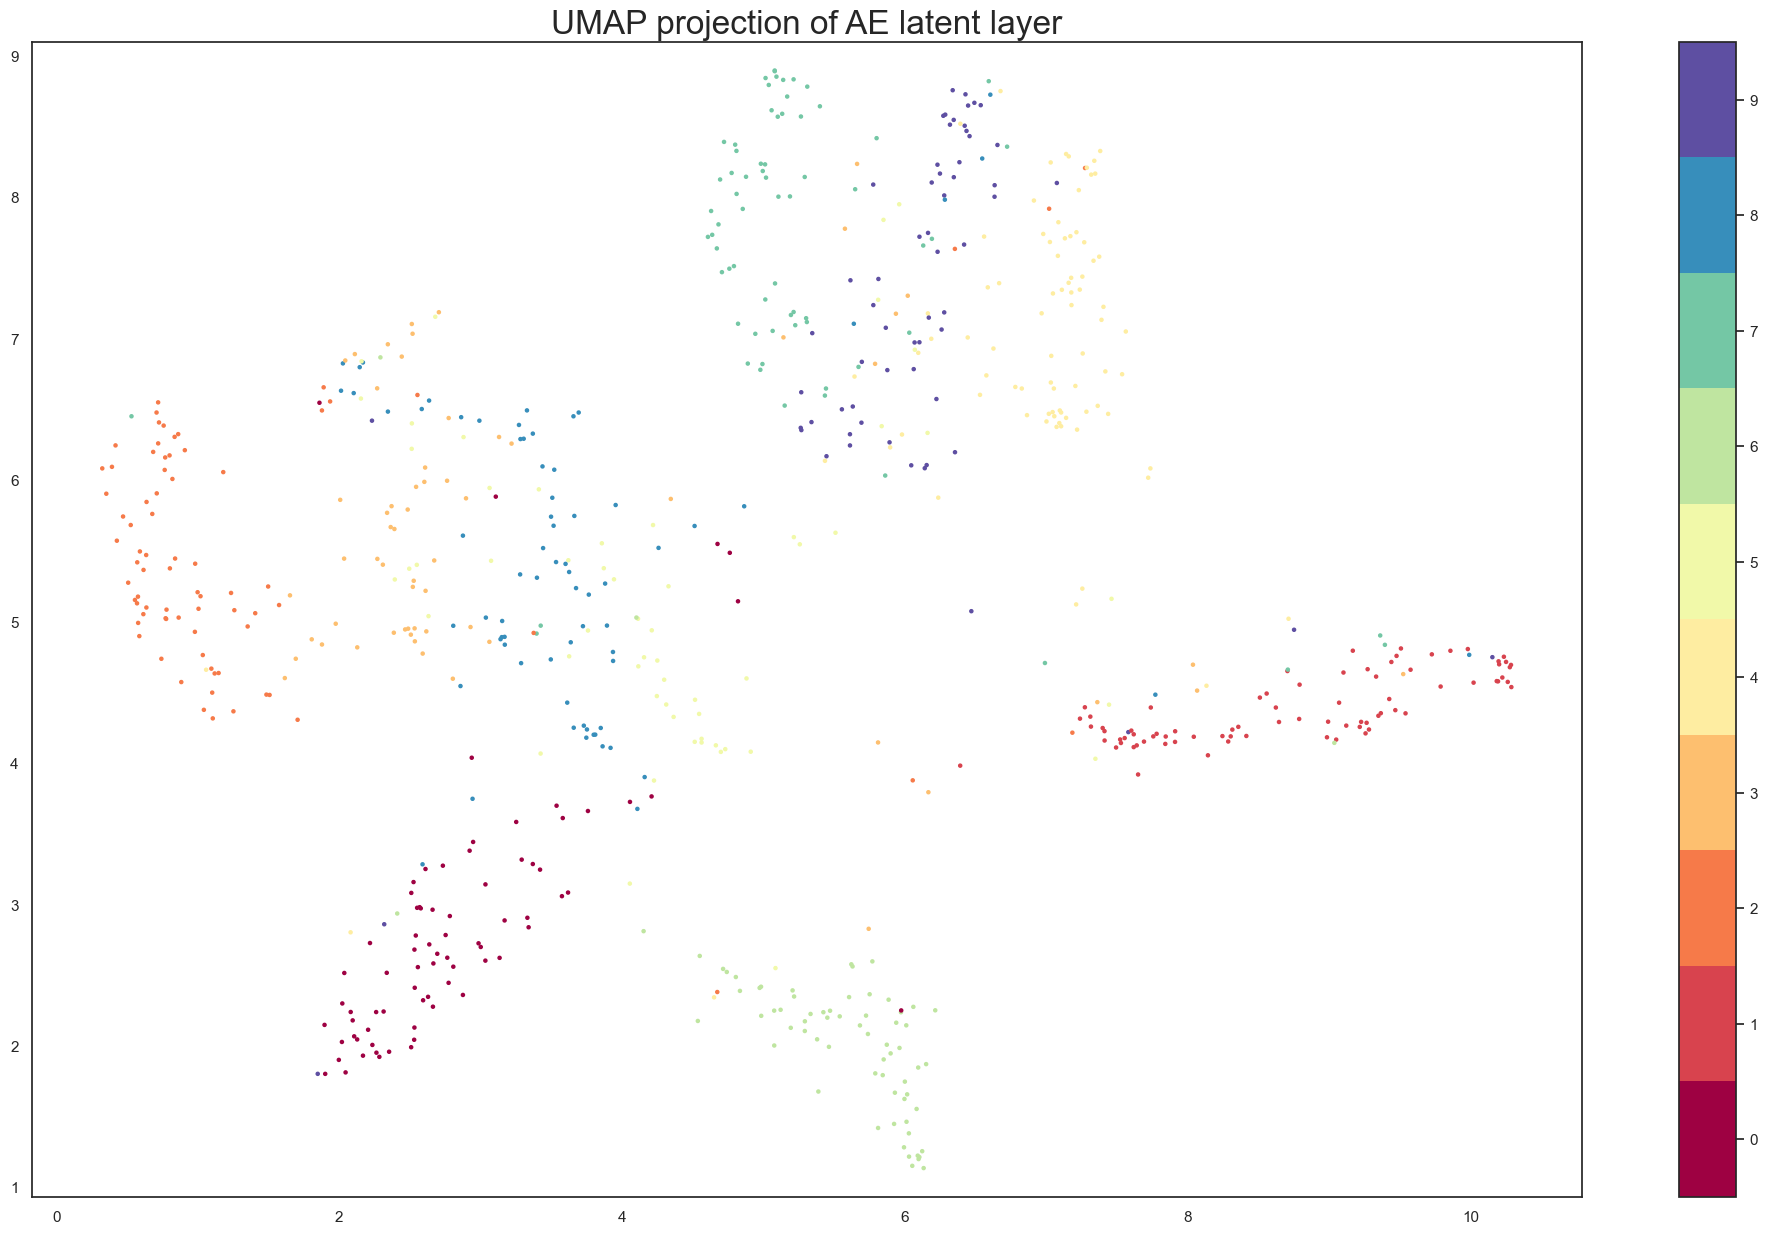

In [35]:
plot_latent_dim(net, train_loader)

In [15]:
# Profiler setup
my_schedule = schedule(skip_first=0, wait=1, warmup=1, active=2, repeat=2)
my_schedule = schedule(skip_first=0, wait=1, warmup=1, active=2, repeat=2)

def trace_handler(p):
    output = p.key_averages().table(sort_by="self_cuda_time_total", row_limit=50)
    print(output)
    p.export_chrome_trace(base_path + "/tmp/trace_" + str(p.step_num) + ".json")

# Run training with profiler
#with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True,
#    schedule=my_schedule, on_trace_ready=trace_handler) as p:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:

    train_loss = net.train_net(train_loader, optimizer, max_batch, start_epoch, max_epoch, save_output=False, save_model=False)
    #test_loss = net.test_net(train_loader, max_batch, start_epoch, max_epoch, save_output=False)
    
# Show
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cuda_time_total", row_limit=30))

Train[0/2][0/938] Loss: 0.2412574291229248
Train[0/2][1/938] Loss: 0.2353697419166565
Train[0/2][2/938] Loss: 0.23845350742340088
Train[0/2][3/938] Loss: 0.23043055832386017
Train[0/2][4/938] Loss: 0.22870972752571106
Train[0/2][5/938] Loss: 0.230546772480011
Train[0/2][6/938] Loss: 0.2346862107515335
Train[0/2][7/938] Loss: 0.23500317335128784
Train[0/2][8/938] Loss: 0.23437409102916718
Train[0/2][9/938] Loss: 0.24121591448783875
Train[1/2][0/938] Loss: 0.22867894172668457
Train[1/2][1/938] Loss: 0.2302873283624649
Train[1/2][2/938] Loss: 0.23779545724391937
Train[1/2][3/938] Loss: 0.22321262955665588
Train[1/2][4/938] Loss: 0.2212371677160263
Train[1/2][5/938] Loss: 0.23417195677757263
Train[1/2][6/938] Loss: 0.227905735373497
Train[1/2][7/938] Loss: 0.23197801411151886
Train[1/2][8/938] Loss: 0.22612155973911285
Train[1/2][9/938] Loss: 0.2296372354030609


In [16]:
print(f'GPU used: {torch.cuda.memory_allocated()}/{torch.cuda.max_memory_allocated()}')

GPU used: 310320640/2729745408


### Show animation

In [ ]:
# Define Network and optimizer
net = SAE_3Dconv()
net = net.to(device)
load_epoch = 19
image_nr = 1

# Load model
net.load_state_dict(torch.load(base_path + f'models/epoch{load_epoch}.pth'))

net = net.eval()
for batch_idx, (real_img, labels) in enumerate(train_loader):
    
    real_img = real_img.permute(0, 2, 1, 3, 4).to(device) # Swap channel and depth pos
    labels = labels.to(device)
    
    #Pass data into network, and return reconstructed image from Membrane Potential at t = -1
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
        with record_function("model_inference"):
            #model(inputs)
            x_recon = net(real_img) #Dimensions passed in: [Batch_size, Channels, Image_Depth, Image_Height, Image_Width]
    
    #Calculate loss
    loss = F.mse_loss(x_recon, real_img)            
    print(f'Loss: {loss.item()}')
    break


Loss: 0.12174132466316223


In [ ]:
# Show
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cuda_time_total", row_limit=30))

-------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                                 Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls                                                                      Input Shapes  
-------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  --------------------------------------------------------------------------------  
                      model_inference       